In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
def create_term_matrix(data_loc, num_vocab, num_documents):
    """ Construct wordcount document matrix 
    X_ij is the number of times word i appears in document j

    Parameters
    ----------
    data_loc : String
        Location of the data file
        
    num_vocab : Integer
        Vocabulary size
        
    num_documents : Integer
        Number of documents
        
    Returns
    ----------
    term_doc : array-like, shape = [num_vocab, num_documents]
        wordcount document matrix
    """ 
    term_doc = np.zeros([num_vocab, num_documents])
    
    with open(data_loc) as file:
        i = 0
        for line in file:
            for info in line.split(','):
                x = info.split(':')
                term_doc[int(x[0])-1][i] = int(x[1])
            i += 1
            
    return term_doc

In [3]:
class NMF_Topic_Model(object):
    """Nonnegative Matrix Factorization based Topic Modeling
    
    Parameters
    ----------        
    term_doc : array-like, shape = [num_vocab, num_documents]
        wordcount document matrix

    num_vocab : Integer
        Vocabulary size
        
    num_documents : Integer
        Number of documents
    
    rank : Integer
        Number of topics to learn
    """
    
    def __init__(self, term_doc, num_vocab, num_documents, rank):
        self.term_doc = term_doc
        self.W = np.random.rand(num_vocab, rank)
        self.H = np.random.rand(rank, num_documents)
        self.objectives = []
        
    def update_data_matrix(self):
        """ Update term data matrix
        
        Returns
        ----------
        X_div : array-like
            term data matrix
        """
        WH = np.dot(self.W, self.H)
        X_div = np.divide(self.term_doc, WH)
        x_nans = np.isnan(X_div)
        X_div[x_nans] = 0

        return X_div
    
    def update_H(self):
        """ Update H matrix (rank X M)
        """
        X_div = self.update_data_matrix()
        normalized_rows = normalize(self.W.T, norm = 'l1', axis = 1)
        matrix_mul = np.matmul(normalized_rows, X_div)
        self.H = np.multiply(self.H, matrix_mul)
        
    def update_W(self):
        """ Update W matrix (N X rank)
        """
        X_div = self.update_data_matrix()
        normalized_cols = normalize(self.H.T, norm = 'l1', axis = 0)
        matrix_mul = np.matmul(X_div, normalized_cols)
        self.W = np.multiply(self.W, matrix_mul)
        
    def calculate_objective(self):
        """ Calculate the current value of the objective function
        
        Returns
        ----------
        objective_val : Float
            objective function value based on current WH
        """
        WH = np.dot(self.W, self.H)
        interaction = np.multiply(self.term_doc, np.log(WH))
        nans = np.isnan(interaction)
        interaction[nans] = 0
        objective_val = -np.subtract(interaction, WH).sum()
        
        return objective_val
        
    def nmf(self, num_iterations):
        """ Perform coordinate ascent and track objective values
        """
        for i in range(num_iterations):
            self.update_H() 
            self.update_W()
            self.objectives.append(self.calculate_objective())
            
    def get_topics(self, vocabulary, num_words):
        """ Get the topics and top words associated with them
        
        Parameters
        ----------
        vocabulary : array-like
            List of words, index corresponds to term_doc
        
        num_words : Integer
            Number of words to return with each topic
        
        Returns
        ----------
        topic_top_words : array-like
            Top words and corresponding weight for each topic
        """
        w = pd.DataFrame(normalize(self.W, norm='l1', axis=0))
        topic_top_words = []
        i = 0
        for topic in w:
            top_words = pd.DataFrame(w[topic]).sort_values(by = topic, ascending = False)[:num_words]
            top_words = top_words.assign(Topic = vocabulary.iloc[top_words.index])
            top_words.rename(columns = {i:'Weight'}, inplace = True)
            top_words.reset_index(inplace = True, drop = True)
            top_words.index += 1
            topic_top_words.append(top_words[['Topic', 'Weight']])
            i+=1
            
        return topic_top_words

In [4]:
# Vocabulary and document size
num_vocab = 3012
num_docs  = 8447

In [5]:
# Creating the term matrix
term_doc = create_term_matrix('data/nyt_data.txt', num_vocab, num_docs)

In [6]:
# Read in the vocabulary
vocabulary = pd.read_csv('data/nyt_vocab.dat', sep = "\n", header = None)

In [7]:
# Set the rank of the matrix we want (number of topics)
rank = 25

In [8]:
# Initialize the model
nyt_topic_model = NMF_Topic_Model(term_doc, num_vocab, num_docs, rank)

In [9]:
# Nonnegative Matrix Factorization
nyt_topic_model.nmf(100)

/Users/jgalsurkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
/Users/jgalsurkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in multiply
/Users/jgalsurkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


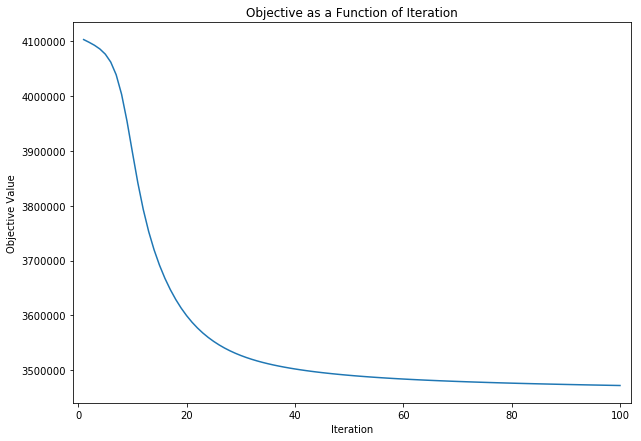

In [10]:
# Plot the objective function
plt.figure(figsize=(10,7))
plt.plot(list(range(1, 101)), nyt_topic_model.objectives)
plt.xlim([-1,102])
plt.title('Objective as a Function of Iteration')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')

In [11]:
# Get the top words for each topic
topics = nyt_topic_model.get_topics(vocabulary, 10)

In [12]:
for topic in topics:
    print(topic, end = '\n\n')

     Topic    Weight
1    thing  0.024034
2      lot  0.017873
3   really  0.014168
4      big  0.012916
5     feel  0.012570
6   little  0.011702
7      ask  0.010970
8      put  0.010951
9     hard  0.010589
10    kind  0.009757

         Topic    Weight
1     american  0.013515
2   government  0.012573
3       states  0.012455
4     military  0.012381
5          war  0.011872
6      country  0.011413
7     official  0.010793
8        force  0.009322
9       leader  0.009131
10      attack  0.007011

          Topic    Weight
1         group  0.015004
2         state  0.014014
3          bill  0.013712
4       program  0.012879
5        policy  0.012293
6      advocate  0.011268
7           law  0.011138
8        public  0.010970
9        debate  0.010854
10  legislation  0.010235

       Topic    Weight
1    percent  0.027545
2      price  0.017274
3       rise  0.017181
4     market  0.017133
5       rate  0.016111
6       fall  0.011849
7        low  0.010754
8    economy  0.01021